<a href="https://colab.research.google.com/github/12-AKSHARA/Spam_sms_detection/blob/main/SPAM_SMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import joblib
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets

Loading and preparing dataset...
Dataset loaded with 5572 messages
Spam messages: 747 (13.41%)
Ham messages: 4825 (86.59%)

Sample messages:


,label,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


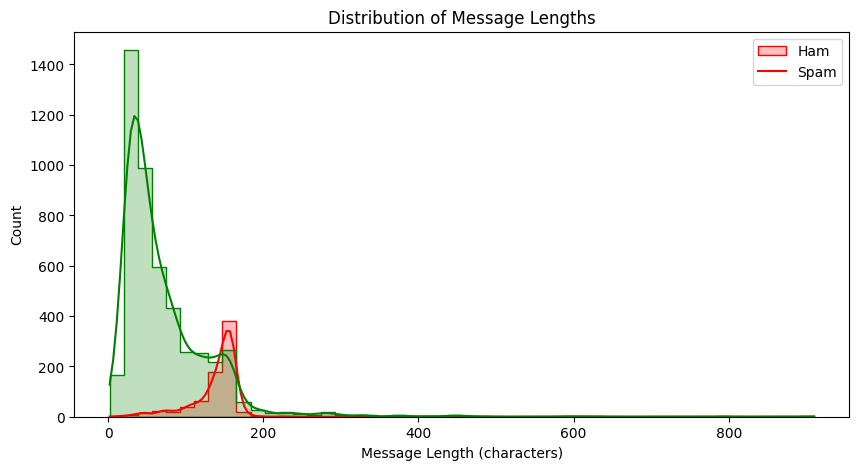

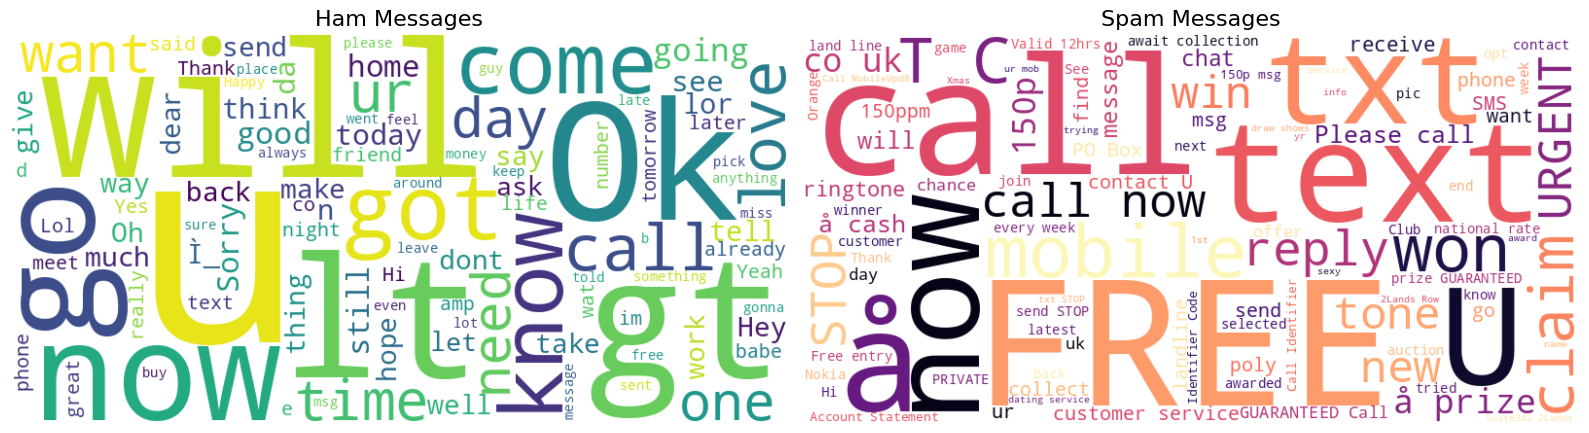


Preprocessing text data...

Sample of cleaned messages:


,Original,Cleaned
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...



Training set: 4457 messages
Testing set: 1115 messages

Vectorizing text data...
Applying SMOTE to handle class imbalance...

Training Naive Bayes...
  • Accuracy: 0.9623
  • Precision: 0.8204
  • Recall: 0.9195
  • F1 Score: 0.8671


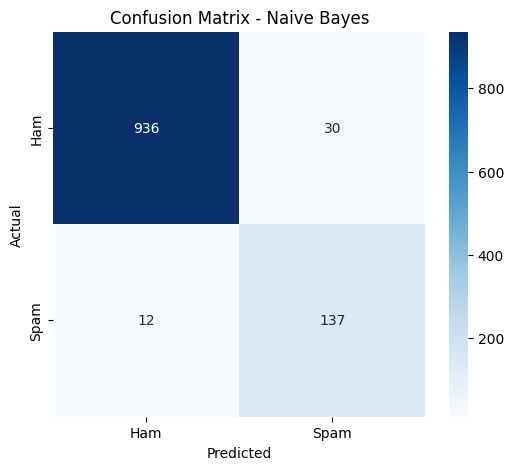


Training Logistic Regression...
  • Accuracy: 0.9767
  • Precision: 0.9073
  • Recall: 0.9195
  • F1 Score: 0.9133


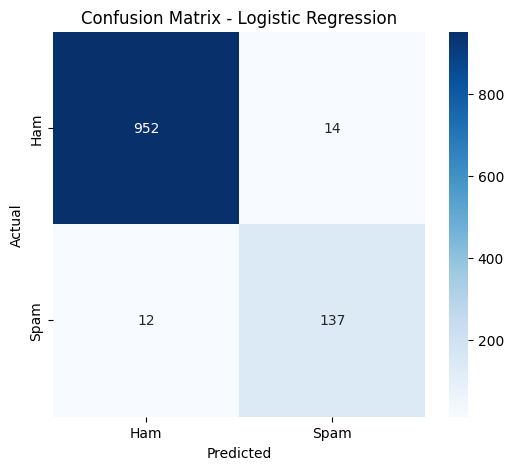


Training Random Forest...
  • Accuracy: 0.9812
  • Precision: 1.0000
  • Recall: 0.8591
  • F1 Score: 0.9242


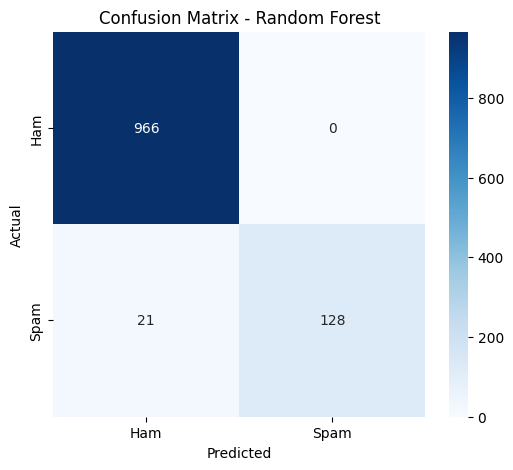


 Best Performing Model: Random Forest
Training final model on full dataset...
Model training complete!
SMS Spam Detector
Enter a message below and click 'Check Message' to classify it.


Textarea(value='', description='Message:', layout=Layout(height='100px', width='100%'), placeholder='Enter an …

Button(button_style='primary', description='Check Message', icon='search', style=ButtonStyle(), tooltip='Click…

Output()

In [12]:


class SMSSpamDetector:
    def __init__(self):
        """Initialize the simplified SMS Spam Detector"""
        nltk.download('stopwords', quiet=True)
        self.stemmer = PorterStemmer()
        self.stopwords = set(stopwords.words('english'))
        self.vectorizer = None
        self.model = None

    def load_and_prepare_data(self, file_path):
        """Load and prepare the SMS dataset"""
        print("Loading and preparing dataset...")

        data = pd.read_csv(file_path, encoding='latin-1')

        if 'v1' in data.columns and 'v2' in data.columns:
            data = data[['v1', 'v2']]
            data.columns = ['label', 'sms']
        else:
            data = data.iloc[:, 0:2]
            data.columns = ['label', 'sms']

        data['label'] = data['label'].apply(lambda x: 1 if x.lower() == 'spam' else 0)

        print(f"Dataset loaded with {len(data)} messages")
        print(f"Spam messages: {data['label'].sum()} ({data['label'].mean()*100:.2f}%)")
        print(f"Ham messages: {len(data) - data['label'].sum()} ({(1-data['label'].mean())*100:.2f}%)")

        print("\nSample messages:")
        display(data.head(3))

        self._visualize_data(data)

        return data

    def _visualize_data(self, data):
        """Create basic visualizations of the dataset"""
        data['length'] = data['sms'].apply(len)

        plt.figure(figsize=(10, 5))
        sns.histplot(data=data, x='length', hue='label', bins=50,
                     kde=True, palette=['green', 'red'], element='step')
        plt.title('Distribution of Message Lengths')
        plt.xlabel('Message Length (characters)')
        plt.legend(['Ham', 'Spam'])
        plt.show()

        plt.figure(figsize=(16, 6))

        plt.subplot(1, 2, 1)
        ham_text = ' '.join(data[data['label'] == 0]['sms'])
        ham_wordcloud = WordCloud(width=800, height=400, background_color='white',
                                 max_words=100, colormap='viridis').generate(ham_text)
        plt.imshow(ham_wordcloud, interpolation='bilinear')
        plt.title('Ham Messages', fontsize=16)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        spam_text = ' '.join(data[data['label'] == 1]['sms'])
        spam_wordcloud = WordCloud(width=800, height=400, background_color='white',
                                  max_words=100, colormap='magma').generate(spam_text)
        plt.imshow(spam_wordcloud, interpolation='bilinear')
        plt.title('Spam Messages', fontsize=16)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    def preprocess_text(self, text):
        """Clean and preprocess text data"""
        text = text.lower()

        text = re.sub(r'https?://\S+|www\.\S+', '', text)

        text = re.sub(r'<.*?>', '', text)

        text = text.translate(str.maketrans('', '', string.punctuation))

        text = re.sub(r'\d+', '', text)

        tokens = text.split()
        tokens = [self.stemmer.stem(word) for word in tokens if word not in self.stopwords]

        text = ' '.join(tokens)

        return text

    def train_model(self, file_path):
        """Train and evaluate spam detection model"""
        data = self.load_and_prepare_data(file_path)

        print("\nPreprocessing text data...")
        data['cleaned'] = data['sms'].apply(self.preprocess_text)

        print("\nSample of cleaned messages:")
        sample_data = pd.DataFrame({
            'Original': data['sms'].head(3).values,
            'Cleaned': data['cleaned'].head(3).values
        })
        display(sample_data)

        X = data['cleaned']
        y = data['label']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)

        print(f"\nTraining set: {len(X_train)} messages")
        print(f"Testing set: {len(X_test)} messages")

        print("\nVectorizing text data...")
        self.vectorizer = TfidfVectorizer(max_features=5000)
        X_train_vec = self.vectorizer.fit_transform(X_train)
        X_test_vec = self.vectorizer.transform(X_test)

        print("Applying SMOTE to handle class imbalance...")
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_vec, y_train)

        models = {
            'Naive Bayes': MultinomialNB(),
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
        }

        results = []

        for name, model in models.items():
            print(f"\nTraining {name}...")

            model.fit(X_train_balanced, y_train_balanced)

            y_pred = model.predict(X_test_vec)

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            print(f"  • Accuracy: {accuracy:.4f}")
            print(f"  • Precision: {precision:.4f}")
            print(f"  • Recall: {recall:.4f}")
            print(f"  • F1 Score: {f1:.4f}")

            results.append({
                'Model': name,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1
            })

            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Ham', 'Spam'],
                       yticklabels=['Ham', 'Spam'])
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title(f'Confusion Matrix - {name}')
            plt.show()

        results_df = pd.DataFrame(results)
        best_model_name = results_df.sort_values(by='F1 Score', ascending=False).iloc[0]['Model']

        print(f"\n Best Performing Model: {best_model_name}")
        print("Training final model on full dataset...")

        X_vec = self.vectorizer.transform(data['cleaned'])

        X_balanced, y_balanced = smote.fit_resample(X_vec, data['label'])

        self.model = models[best_model_name]
        self.model.fit(X_balanced, y_balanced)

        print("Model training complete!")
        return self.model, self.vectorizer

    def predict(self, message):
        """Predict whether a message is spam or not"""
        if self.model is None or self.vectorizer is None:
            print("Model not trained. Please train the model first.")
            return None, None

        cleaned_message = self.preprocess_text(message)

        message_vec = self.vectorizer.transform([cleaned_message])

        prediction = self.model.predict(message_vec)[0]

        if hasattr(self.model, 'predict_proba'):
            probability = self.model.predict_proba(message_vec)[0][prediction]
        else:
            decision = self.model.decision_function(message_vec)[0]
            probability = 1 / (1 + np.exp(-decision))

        return prediction, probability

    def create_interactive_interface(self):
        """Create an interactive UI for message classification"""
        if self.model is None or self.vectorizer is None:
            print("Model not trained. Please train the model first.")
            return

        message_input = widgets.Textarea(
            value='',
            placeholder='Enter an SMS message here to check if it is spam or not...',
            description='Message:',
            disabled=False,
            layout=widgets.Layout(width='100%', height='100px')
        )

        check_button = widgets.Button(
            description='Check Message',
            button_style='primary',
            tooltip='Click to check if the message is spam',
            icon='search'
        )

        output = widgets.Output()

        def on_button_clicked(b):
            with output:
                clear_output()
                message = message_input.value

                if not message.strip():
                    print("⚠️ Please enter a message to classify.")
                    return

                prediction, probability = self.predict(message)

                if prediction == 1:
                    result_html = f"""
                    <div style="background-color: #ffebee; border-left: 5px solid #f44336; padding: 10px; margin: 10px 0;">
                        <h3 style="color: #d32f2f; margin: 0;"> Spam Detected</h3>
                        <p style="margin: 10px 0 0 0;">This message is classified as <strong>spam</strong> with {probability * 100:.2f}% confidence.</p>
                    </div>
                    """
                else:
                    result_html = f"""
                    <div style="background-color: #e8f5e9; border-left: 5px solid #4caf50; padding: 10px; margin: 10px 0;">
                        <h3 style="color: #2e7d32; margin: 0;"> Ham (Not Spam)</h3>
                        <p style="margin: 10px 0 0 0;">This message is classified as <strong>legitimate</strong> with {probability * 100:.2f}% confidence.</p>
                    </div>
                    """

                display(HTML(result_html))

                print("Original message:")
                print(f'"{message}"')

                print("\nPreprocessed text:")
                print(f'"{self.preprocess_text(message)}"')

        check_button.on_click(on_button_clicked)

        print("SMS Spam Detector")
        print("Enter a message below and click 'Check Message' to classify it.")
        display(message_input, check_button, output)

def run_spam_detector(dataset_path='spam.csv'):
    detector = SMSSpamDetector()
    detector.train_model(dataset_path)
    detector.create_interactive_interface()
    return detector
detector = run_spam_detector('spam.csv')